In [1]:
# some startup! 
import numpy as np
import matplotlib
# This is needed to save images 
matplotlib.use('Agg')
import matplotlib.pyplot as plt

%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap


# Make sure that caffe is on the python path
caffe_root = '/Users/mohamed/Code/lib/caffe'
import sys
sys.path.insert(0, caffe_root + 'python')

# should work if you have made pycaffe
import caffe
import os


In [76]:
caffe.set_mode_cpu() # change to gpu if your machine has one 
# when you visualize the 2 layer NN / convnet, make sure to put appropriate paths 
# for the below fields
PRETRAINED = '/Users/mohamed/Code/lib/caffe/snapshot_iter_600.caffemodel'
MODEL = '/Users/mohamed/Code/lib/caffe/deploy.prototxt'

os.environ['GLOG_minloglevel'] = '2' 

net = caffe.Classifier(MODEL, PRETRAINED)

In [77]:
channels = 3
s = int(128)

a = caffe.io.caffe_pb2.BlobProto()
with open("/Users/mohamed/Code/lib/DIGITS/digits/jobs/20160325-143423-10cd/mean.binaryproto",'rb') as f:
    a.ParseFromString(f.read())

means = a.data
means = np.asarray(means)
print means.shape

mu=means.reshape(channels,s,s)
print mu.shape

(49152,)
(3, 128, 128)


In [78]:
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: [('B', 128.37103271484375), ('G', 130.8646240234375), ('R', 166.11578369140625)]


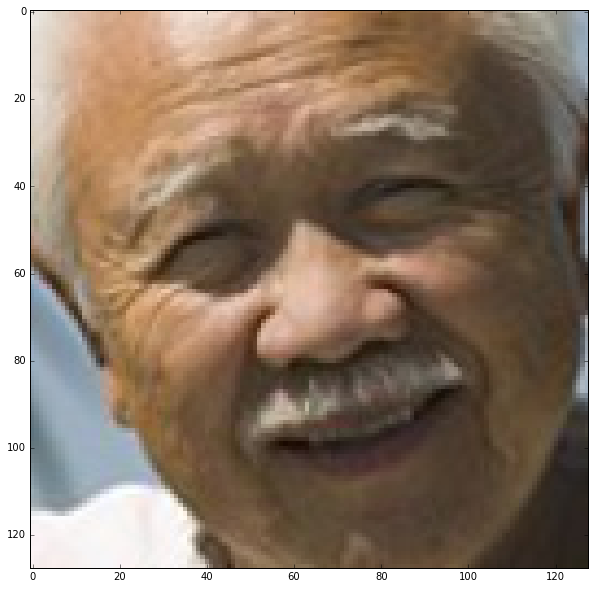

In [102]:
image = caffe.io.load_image("/Users/mohamed/Documents/test4_face.jpg")
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)

In [103]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

### perform classification
output = net.forward()

output_prob = output['prob'][0]  # the output probability vector for the first image in the batch

print 'predicted class is:', output_prob.argmax()

predicted class is: 4


In [23]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

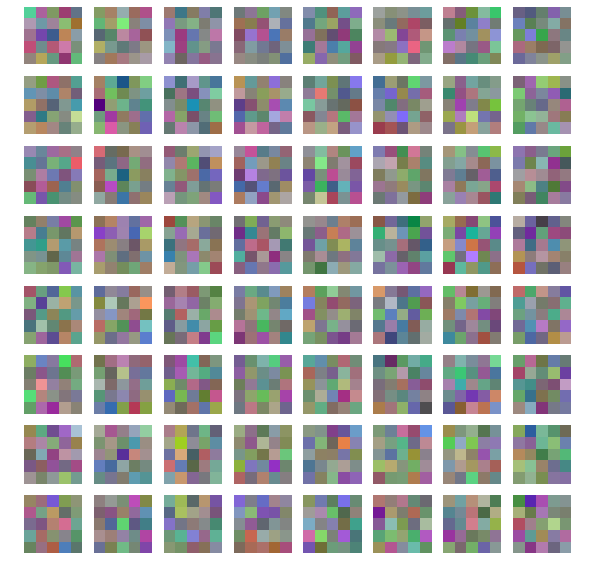

In [24]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))